# PPI power analysis

This notebook demonstrates the PPI power analysis from [3, Section 3].  The power analysis returns two samples sizes: $n$ - the number of labeled samples and $N$ - the number of unlabaled samples. The power analysis is for PPI++ with power tuning [2, Section 6].

Two types of power analysis are implemented, the most powerful pair and the cheapest pair. **The most powerful pair** returns the pair $(n, N)$ that minimizes the standard error of the PPI estimator subject to a constraint on the cost. **The cheapest pair** returns the pair $(n, N)$ that minimizes the cost subject to a constraint on the standard error.

The power analysis is **data driven**. To perform the power analysis, the user must supply a preliminary dataset with both gold-standard labels $Y_i$ and predicted labels $\hat{Y}_i$. The power analysis then returns an optimal pair of samples $(n, N)$ for a new experiment.

The power analysis also returns two measurements of the effectiveness of PPI, the PPI correlation and the effective sample size. The **PPI correlation** measures how well the predictions match the gold-standard labels for the specific inference task. The **effective sample size** is the number of gold-standard labels that would be needed for classical inference to achieve the same level of power as PPI.

The power analysis is implemented for inference on the mean, linear regression coefficients and generalized linear model coefficients. There is also a generic function that requires the user to supply the PPI correlation.

    
References 
* [1] Angelopoulos, A. N., Bates, S., Fannjiang, C., Jordan, M. I., & Zrnic, T. (2023). Prediction-powered inference. Science, 382(6671), 669-674.  https://www.science.org/doi/full/10.1126/science.adi6000 
* [2] Angelopoulos, A. N., Duchi, J. C., & Zrnic, T. (2023). PPI++: Efficient prediction-powered inference. https://arxiv.org/abs/2311.01453
* [3] Broska, D., Howes, M., & van Loon, A. (2024). The Mixed Subjects Design: Treating Large Language Models as  (Potentially) Informative Observations. https://doi.org/10.31235/osf.io/j3bnt



In [34]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import matplotlib.pyplot as plt
from ppi_py.datasets import load_dataset
from ppi_py.power_ppi import (
    ppi_power,
    ppi_mean_power,
    ppi_ols_power,
    ppi_poisson_power,
)
from ppi_py.ppi import ppi_mean_ci, ppi_ols_ci, ppi_poisson_ci
from scipy.optimize import brentq
from scipy.stats import norm, foldnorm
from utils import *
import warnings

warnings.simplefilter("always", UserWarning)
np.random.seed(0)  # For reproducibility

## Power analysis for the mean

The function `ppi_mean_power` performs a power analysis for estimating the mean of $Y$. This function is demonstrated on the `ballots` dataset from [1]. 

The output from `ppi_mean_power` is a dictionary containing
* `n` -- the number of labeled samples
* `N` -- the number of unlabeled samples
* `cost` -- the total cost of gathering `n` labeled and `N` unlabed samples and performing PPI
*  `se` -- the standard error of the PPI point estimate with `n` labeled and `N` unlabeled samples
* `ppi_corr` -- the *PPI correlation* [3, Section 3]
* `effective_n` -- the *effective sample size* this is the number of labeled samples required for the classical estimate to match the PPI point estimate

The function `ppi_mean_power` requires the following inputs
* `Y` -- the gold-standard labels $\{Y_i\}_{i=1}^n$
* `Yhat` -- the predictions on the labeled data $\{f(X_i)\}_{i=1}^n$
* `Yhat_unlabeled` -- the prediction on unlabeled data $\{f(\widetilde{X}_i)\}_{i=1}^N$.
* `cost_Y` -- the cost of a gold-standard label
* `cost_Yhat` -- the cost of a prediction
* Either `budget` (for the most powerful pair) or `se` (for the cheapest pair).

### The most powerful pair

The most powerful pair is computed by giving `budget` as an input to `ppi_power_mean`. The below code compute the most powerful pair assuming `cost_Y = 1`, `cost_Yhat = 0.1` and `budget = 1000`. These costs mean that predictions are ten times cheaper than gold standard labels and that the budget can buy 1,000 gold-standard labels. In this example, using PPI with the optimal sample sizes is equivalent to having over 3,000 gold-standard labels.



In [35]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]
Yhat_unlabeled = data["Yhat_unlabeled"]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]

n_initial = 500
N_initial = 500

labeled_initial = np.random.choice(n, n_initial, replace=False)
unlabeled_initial = np.random.choice(N, N_initial, replace=False)

Y_initial = Y[labeled_initial]
Yhat_initial = Yhat[labeled_initial]
Yhat_unlabeled_initial = Yhat_unlabeled[unlabeled_initial]

budget = 1000
cost_Y = 1
cost_Yhat = 0.1

powerful_pair = ppi_mean_power(
    Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, budget = budget
)

powerful_pair

{'n': 444,
 'N': 5112,
 'cost': 999.6,
 'se': np.float64(0.008487472148317653),
 'ppi_corr': np.float64(0.9694815407698035),
 'effective_n': 3283}

The below plot shows optimality of the most powerful pair. The pair of sample sizes $(n, N)$ achieves the budget and gives the smallest possible standard error within the budget.

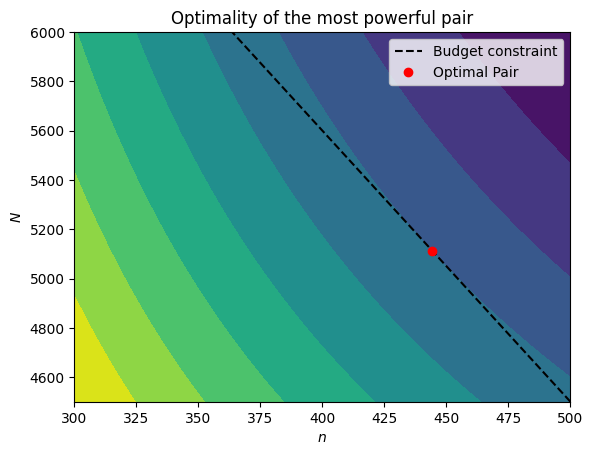

In [36]:
n_opt = powerful_pair["n"]
N_opt = powerful_pair["N"]
rho = powerful_pair["ppi_corr"]

n = np.linspace(300, 500, 100)
N = np.linspace(4500, 6000, 100)

ns, Ns = np.meshgrid(n, N)
def ppi_se(n, N, rho):
    return np.sqrt(1/n * (1 - rho**2 * N /(n + N)))

ses = ppi_se(ns, Ns, rho)
m = np.min(ses)
M = np.max(ses)
se_opt = ppi_se(n_opt, N_opt, rho)
levels = np.concat([np.linspace(m, se_opt, 4), np.linspace(se_opt, M, 7)[1:]])

plt.contourf(ns, Ns, ses, levels=levels)

n_cost = (budget - (cost_Yhat * N))/(cost_Yhat+cost_Y)
plt.plot(n_cost, N, 'k--', label='Budget constraint') 

plt.plot(n_opt, N_opt, 'ro', label='Optimal Pair')
# latex labels
plt.xlabel('$n$')

plt.ylabel('$N$')
plt.title('Optimality of the most powerful pair')
plt.legend()
plt.show()

### The cheapest pair

The cheapest pair is computed by giving `se` as an input to `ppi_mean_power`. The below code compute the cheapest pair achieving a standard error of $0.0025$. The same preliminary data and costs are taken from the previous example.


In [37]:
se = 0.0025
cheapest_pair = ppi_mean_power(
    Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, se = se
)
cheapest_pair

{'n': 5119,
 'N': 58899,
 'cost': 11520.8,
 'se': np.float64(0.0025000583354539314),
 'ppi_corr': np.float64(0.9694815407698035),
 'effective_n': 37845}

## Power analysis for regression coefficients

The functions `ppi_<estimand>_power` perform the PPI power analysis for other estimands. The currently implemented estimands are

* Linear regression `ppi_ols_power`
* Logisitic regression `ppi_logisitic_power`
* Poisson regression `ppi_poisson_power`

These power analyses are data driven. The user must provide `X`, `Y`, `Yhat`, `X_unlabeled` and `Yhat_unlabeled`. The user must also supply a coordinate specifying the regression coefficient of interest. The following costs are also required `cost_X` (the cost of gathering $X$), `cost_Y` (the cost of gathering the label $Y$) and `cost_Yhat` (the cost of making a prediction $f(X)$).

The functions `ppi_<estimand>_power` can compute either the most powerful pair (by providing `budget`) or the cheapest pair (by providing `se`).

### Power analysis for linear regression

The function `ppi_poisson_power` performs a data-driven power analysis for linear regression. This is illustrated using the `census_income` dataset from [1]. The cheapest pair $(n, N)$ achieving a standard error of 50 is computed.

In [39]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace=False)
Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]


cost_X = 0.01
cost_Y = 1
cost_Yhat = 0.01
coord = 0
se = 50

cheapest_pair = ppi_ols_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    se=se,
)
cheapest_pair

{'n': 4957,
 'N': 14003,
 'cost': 5336.2,
 'se': np.float64(50.00067986362375),
 'ppi_corr': np.float64(0.475775616458309),
 'effective_n': 5952}

### Power analysis for Poisson regression


The fucntion `ppi_poisson_power` performs a power analysis for Poisson regression. This is done with the `census_education` dataset from [1]. The most powerful pair within a budget of 5000 is computed.

In [42]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"] / 10000  # scale

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace=False)

Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_X = 0.1
cost_Y = 0.9
cost_Yhat = 0.01
budget = 5000

coord = 0

most_powerful_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    budget = budget
)
most_powerful_pair

{'n': 4489,
 'N': 4235,
 'cost': 4999.74,
 'se': np.float64(67.39753620698625),
 'ppi_corr': np.float64(0.5620024934499269),
 'effective_n': 5301}

## Power analysis with a bound on the number of unlabeled samples



## Power analysis with known $\tilde{\rho}$

The function `ppi_power` computes an optimal pair of sample sizes given the PPI-correlation $\tilde{\rho}$ [BHvL24], and $\sigma^2$ the asymptotic variance of the classical point estimate. The user must also supply the costs of $Y$, $f(X)$ and $X$. 

The output is a dictionary containing 
* `n` -- the number of labeled samples
* `N` -- the number of unlabeled samples
* `cost` -- the total cost of gathering `n` labeled and `N` unlabed samples and performing PPI
*  `se` -- the standard error of the PPI point estimate with `n` labeled and `N` unlabeled samples
* `rho` -- the user supplied PPI correlation
* `effective_n` -- the *effective sample size* this is the number of labeled samples required for the classical estimate to match the PPI point estimate.

The function `ppi_power` has two options. If `budget` is supplied, then the function will compute the *most powerful pair*. If `se` is supplied, then the function will compute the *cheapest pair*.

### Power analysis for the most powerful pair

When `budget` is supplied, `ppi_power` will compute the pair of sample sizes (`n`, `N`) that minimize the standard error while staying with the given budget.

In [11]:
rho = 0.95
sigma_sq = 1
cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01

budget = 864

optimal_pair = ppi_power(
    sigma_sq, rho, cost_Y, cost_Yhat, cost_X, budget=budget
)
optimal_pair

{'n': 855,
 'N': 0,
 'cost': 863.55,
 'se': 0.03419927840283847,
 'ppi_corr': 0.95,
 'effective_n': 855}

The function `ppi_power` has an optional input called `n_max`. This input should be provided if there is a limit on the total number of samples. When `n_max` is provided, the output will satisfy the additional constraint `n + N <= n_max`.

In [13]:
n_max = 10000
optimal_pair = ppi_power(
    sigma_sq, rho, cost_Y, cost_Yhat, cost_X, budget=budget, n_max=n_max
)
optimal_pair

{'n': 855,
 'N': 0,
 'cost': 863.55,
 'se': 0.03419927840283847,
 'ppi_corr': 0.95,
 'effective_n': 855}

The following plot shows that the new optimal pair satisfies `n + N <= n_max`.

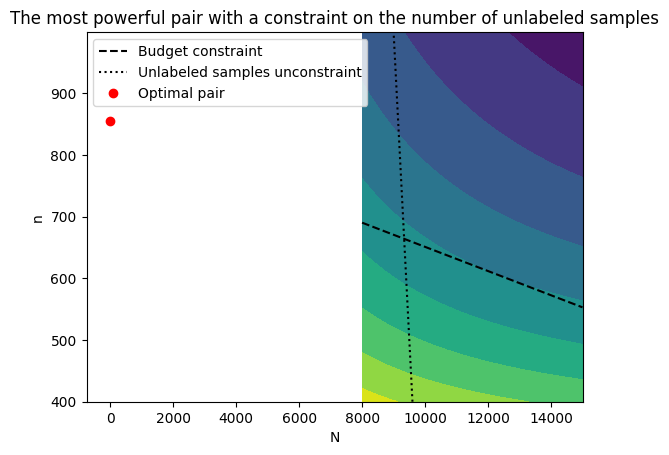

In [14]:
n = np.arange(400, 1000)
N = np.arange(8000, 15000)
ns, Ns = np.meshgrid(n, N)
ppi_se = np.sqrt(sigma_sq / ns * (1 - Ns / (Ns + ns) * rho**2))
plt.contourf(Ns, ns, ppi_se)
n_cost = (budget - N * (cost_X + cost_Yhat)) / (cost_X + cost_Y + cost_Yhat)
N_max_constraint = n_max - n


plt.plot(N, n_cost, "k--", label="Budget constraint")
plt.plot(N_max_constraint, n, "k:", label="Unlabeled samples unconstraint")

n_opt = optimal_pair["n"]
N_opt = optimal_pair["N"]

plt.plot(N_opt, n_opt, "ro", label="Optimal pair")
plt.legend()
plt.xlabel("N")
plt.ylabel("n")
plt.title(
    "The most powerful pair with a constraint on the number of unlabeled samples"
)
plt.show()

### Power analysis for the cheapest pair

If the input `se` is provided instead of `budget`, then `ppi_power` will compute the *cheapest pair*. This is the pair (`n`, `N`) that minimizes the cost while achieving a PPI standard error of `se`. 

In [15]:
rho = 0.95
sigma_sq = 1
cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01

se = 0.00975

optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se=se)
optimal_pair

{'n': 10519,
 'N': 0,
 'cost': 10624.19,
 'se': 0.009750183122346415,
 'ppi_corr': 0.95,
 'effective_n': 10519}

The below plot shows that the computed pair achieves the lowest cost subject to achieving the given standard error. The standard error of the pair (`n`, `N`) matches the desired level `se`. And, at the point (`n`, `N`) the level curve of the standard error is tangent to the level curves of the budget.

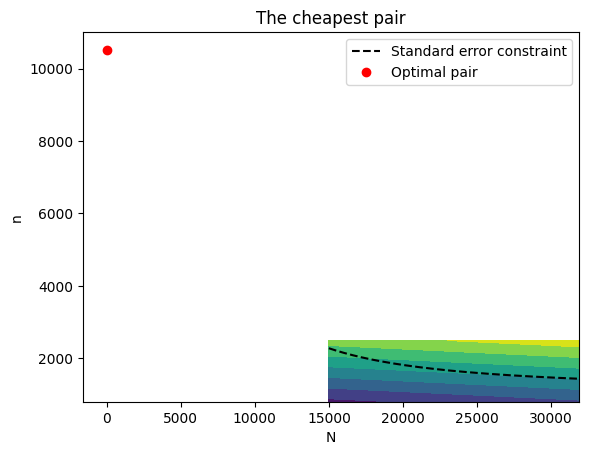

In [16]:
n = np.arange(800, 2500, 10)
N = np.arange(15000, 32000, 100)
ns, Ns = np.meshgrid(n, N)
costs = ns * (cost_X + cost_Yhat + cost_Y) + Ns * (cost_X + cost_Yhat)
plt.contourf(Ns, ns, costs)

n_se = (
    (
        -(se**2) * N
        + sigma_sq
        + (
            se**4 * N**2
            + 2 * se**2 * N * sigma_sq
            - 4 * se**2 * N * rho**2 * sigma_sq
            + sigma_sq**2
        )
        ** 0.5
    )
    / 2
    / se**2
)
plt.plot(N, n_se, "k--", label="Standard error constraint")

n_opt = optimal_pair["n"]
N_opt = optimal_pair["N"]
plt.plot(N_opt, n_opt, "ro", label="Optimal pair")
plt.xlabel("N")
plt.ylabel("n")
plt.title("The cheapest pair")
plt.legend()
plt.show()

By providing `n_max` to `ppi_power`, the output will satisfy the additional constraint `n+N <= n_max`.

In [17]:
n_max = 25000
optimal_pair = ppi_power(
    sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se=se, n_max=n_max
)
print(optimal_pair)

{'n': 10519, 'N': 0, 'cost': 10624.19, 'se': 0.009750183122346415, 'ppi_corr': 0.95, 'effective_n': 10519}


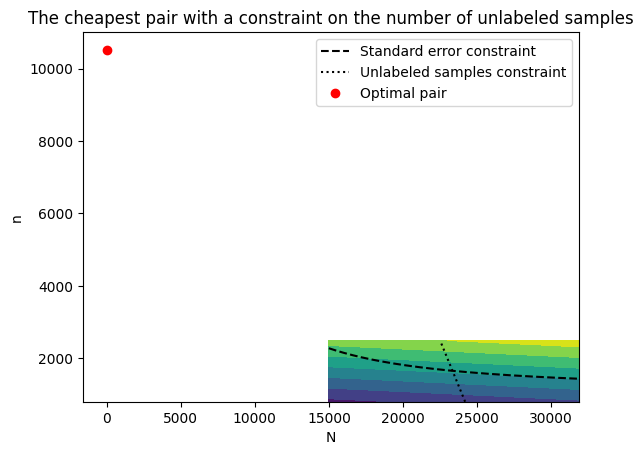

In [18]:
plt.contourf(Ns, ns, costs)
plt.plot(N, n_se, "k--", label="Standard error constraint")

N_max_constraint = n_max - n
plt.plot(N_max_constraint, n, "k:", label="Unlabeled samples constraint")

n_opt = optimal_pair["n"]
N_opt = optimal_pair["N"]
plt.plot(N_opt, n_opt, "ro", label="Optimal pair")
plt.legend()
plt.xlabel("N")
plt.ylabel("n")
plt.title(
    "The cheapest pair with a constraint on the number of unlabeled samples"
)
plt.show()

It is possible that no pair of sample sizes can achieve the desired `se` and satisfy `n + N <= n_max`. In this case, `ppi_power` will give a warning and return `n = n_max` and `N = 0`. This pair gives the smallest standard error under the constraint `n + N <= n_max`.

In [19]:
n_max = 10000
optimal_pair = ppi_power(
    sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se=se, n_max=n_max
)
print(optimal_pair)

{'n': 10000, 'N': 0, 'cost': 10100.0, 'se': 0.01, 'ppi_corr': 0.95, 'effective_n': 10000}


c:\Users\micha\Documents\GitHub\ppi_py\ppi_py\power_ppi.py:262: UserWarning: The desired standard error is too small for the given number of unlabeled samples. 
Returning n = n_max and N = 0. To achieve the desired standard error, increase n_max or decrease se.
  warnings.warn(


### Computing a desired standard error

The cheapest pair requires the user to provide a desired standard error. In some cases, a researcher will have a desired level of power instead of a desired level of power. To translate the desired level of power, the researcher must supply a desired effectsize $\delta = \theta_1 - \theta_0$ and a level of type 1 error $\alpha$. To achieve the type 1 error $\alpha$ and a type 2 error of $\beta$ with the effectsize $\delta$, the desired standard error $s$ is given by solving 

$$ P(|\delta/s + Z| > z_{1-\alpha/2}) = 1-\beta,$$

where $Z \sim \mathcal{N}(0,1)$ and $z_{1-\alpha/2}$ is the $1-\alpha/2$ quantile of the normal distribution. The function `se_from_power` computes the desired standard error given `effect_size` ($\delta$), `power` ($1-\beta$) and `level` ($\alpha$).

In [20]:
def se_from_power(effect_size, power, level=0.05):
    assert 0 < power < 1, "Power must be between 0 and 1"
    assert 0 < level < 1, "Level must be between 0 and 1"
    assert 0 != effect_size, "Effect size must be non-zero"
    assert power > level, "Power must be greater than level"
    q = norm.ppf(1 - level / 2)
    beta = 1 - power

    def f(d):
        return foldnorm.cdf(q, c=d) - beta

    a = 0
    b = q - norm.ppf(beta)
    d_star = brentq(f, a, b)
    se = effect_size / d_star
    return se

The function `se_from_power` can be used to compute the cheapest pair achieving a given level of power.

In [21]:
level = 0.05
power = 0.8
effect_size = 0.3
se = se_from_power(effect_size, power, level)

optimal_pair = ppi_power(sigma_sq, rho, cost_Y, cost_Yhat, cost_X, se=se)
print(optimal_pair)

{'n': 87, 'N': 0, 'cost': 87.87, 'se': 0.10721125348377948, 'ppi_corr': 0.95, 'effective_n': 87}


## Poisson regression power analysis

The fucntion `ppi_poisson_power` performs a power analysis for Poisson regression. This is done with the `census_education` dataset from [1]. The most powerful


In [44]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"] / 10000  # scale

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace=False)

Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01


coord = 0

most_powerful_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_Y,
    cost_Yhat,
    cost_X,
    coord,
    budget=5000,
)
most_powerful_pair

{'n': 4476,
 'N': 21704,
 'cost': 4999.6,
 'se': np.float64(57.96462955407703),
 'rho': np.float64(0.6373552947893552),
 'effective_n': 6748}

In [45]:
cheapest_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_Y,
    cost_Yhat,
    cost_X,
    coord,
    se=30,
)
cheapest_pair

{'n': 16709,
 'N': 81020,
 'cost': 18663.58,
 'se': np.float64(30.000826406523615),
 'rho': np.float64(0.6373552947893552),
 'effective_n': 25193}

In [46]:
n_opt = most_powerful_pair["n"]
N_opt = most_powerful_pair["N"]

reps = 100
ses = np.zeros(reps)
for i in range(reps):
    sample = np.random.choice(n_total, n_opt + N_opt, replace=False)
    Y_opt = Y_total[sample[:n_opt]]
    Yhat_opt = Yhat_total[sample[:n_opt]]
    X_opt = X_total[sample[:n_opt]]
    Yhat_unlabeled_opt = Yhat_total[sample[n_opt:]]
    X_unlabeled_opt = X_total[sample[n_opt:]]

    CI = ppi_poisson_ci(
        X_opt,
        Y_opt,
        Yhat_opt,
        X_unlabeled_opt,
        Yhat_unlabeled_opt,
        alpha=0.05,
        coord=coord,
    )
    ses[i] = (CI[1][coord] - CI[0][coord]) / norm.ppf(1 - 0.05 / 2) / 2

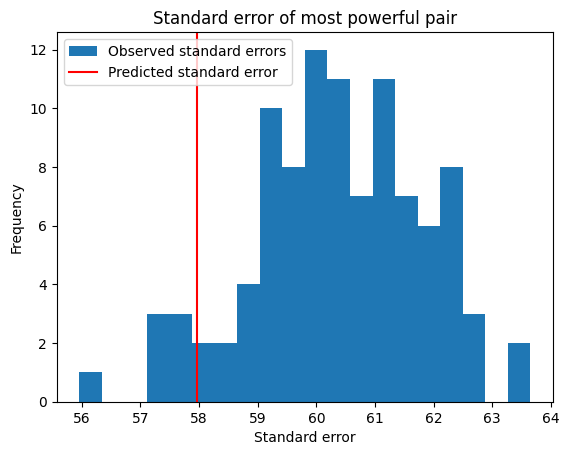

In [47]:
plt.hist(ses, bins=20, label="Observed standard errors")
plt.axvline(
    most_powerful_pair["se"], color="red", label="Predicted standard error"
)
plt.legend()
plt.title("Standard error of most powerful pair")
plt.xlabel("Standard error")
plt.ylabel("Frequency")
plt.show()